# 01. Importing Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = '8hUvzsaSPcx45C5BBc6_'

In [3]:
# Importing the Federal Reserve Economic Data "Median Sales Price of Houses Sold for the United States" variable.

data = quandl.get('FRED/MSPUS')

In [4]:
data.head(10)

,Value
Date,
1963-01-01,17800.0
1963-04-01,18000.0
1963-07-01,17900.0
1963-10-01,18500.0
1964-01-01,18500.0
1964-04-01,18900.0
1964-07-01,18900.0
1964-10-01,19400.0
1965-01-01,20200.0


In [5]:
data.shape

(236, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

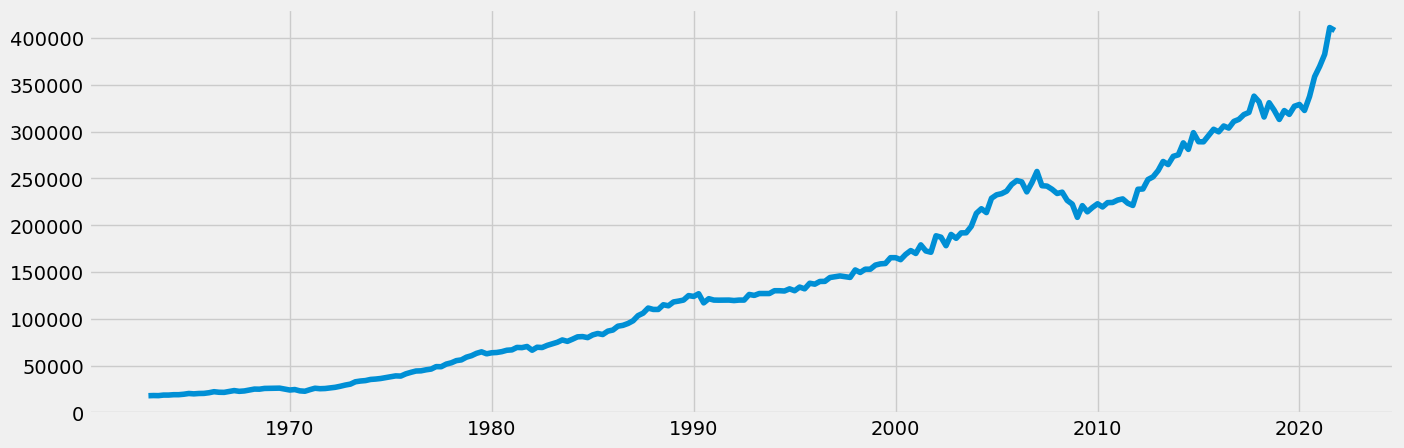

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here.

plt.plot(data)

Based on the above graph, we can see that the median price of US houses sold has been steadily increasing since 1960, having only experienced a dip between 2008-2010, which was the period during the financial crisis that was also largely associated with the housing market bubble crashing. Since 2020, we've seen an exponential spike in the value of house prices sold, which (outside of this task) highlights that we should prepare for a very significant crash soon that will likely also impact or also help lead to another market dip/recession.  

Overall, we can see that the data is not stationary as there is a clear trend updwards over time. 

# 02. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Resetting index to use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1963-01-01,17800.0
1,1963-04-01,18000.0
2,1963-07-01,17900.0
3,1963-10-01,18500.0
4,1964-01-01,18500.0


As the market coniditons have changed dramatically since the 1960s-1990s, and the median housing prices in 1960-1970 were somewhere around 25,000 USD and "only" around 75,000 in 1980, we will remove all observations prior to 1990. I personally do not know of anyone in the US (having been born there) who still is able to find a house anywhere for less than 150-180k (small, 3-4 room house with little to no garden and in a "less than desirable" location. As such, I will trim the dataset to 1990 to present so to avoid any data that may incorrectly influence my calculations.  

In [11]:
## Use desc stats to determine most current data available

data_2['Date'].describe()

count                     236
unique                    236
top       1963-01-01 00:00:00
freq                        1
first     1963-01-01 00:00:00
last      2021-10-01 00:00:00
Name: Date, dtype: object

In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2021-10-01')]

In [13]:
data_sub.shape

## Note - removed about half of the observations

(127, 2)

In [14]:
data_sub.head()

,Date,Value
108,1990-01-01,123900.0
109,1990-04-01,126800.0
110,1990-07-01,117000.0
111,1990-10-01,121500.0
112,1991-01-01,120000.0


In [15]:
# Setting "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-01-01,123900.0
1990-04-01,126800.0
1990-07-01,117000.0
1990-10-01,121500.0
1991-01-01,120000.0


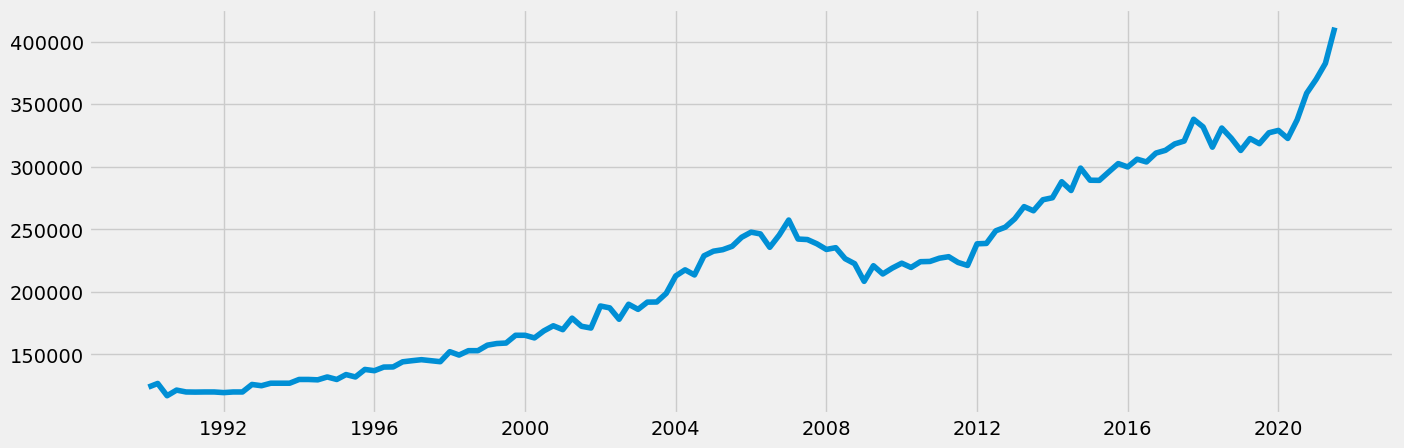

In [16]:
## Plotting the new data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

Plot still shows a very clear upward trend, having begun in the mid 1990s and then seeing very significant increases around early 2000s and early 2010s and 2020s

In [17]:
# Checking for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# I'm not entirely sure how duplicates are being created after simply trimming the dataframe?
## I ran a duplicates test for the data and data_2 df's and there were none. 

13

In [19]:
data_sub.head(127)

,Value
datetime,
1990-01-01,123900.0
1990-04-01,126800.0
1990-07-01,117000.0
1990-10-01,121500.0
1991-01-01,120000.0
...,...
2020-07-01,337500.0
2020-10-01,358700.0
2021-01-01,369800.0


Having looked at the dataframe, to me it's clear that in some cases, the median housing prices remained the same quarter to quarter and from my view, do not seem problematic in that sense, as they have different datetime values. In some cases, the median house price may increase from one quarter to the next but may decrease after that to a similar value in a previous year and/or quarter. We can see that between 1991-04-01 and 1992-07-01, the median house price sold was 120,000 on five occasions.

Based on my above observations, I am somewhat unsure if it is necessary to remove these values for the stationary analysis or not. 

# 03. Time-series analysis: decomposition

In [20]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

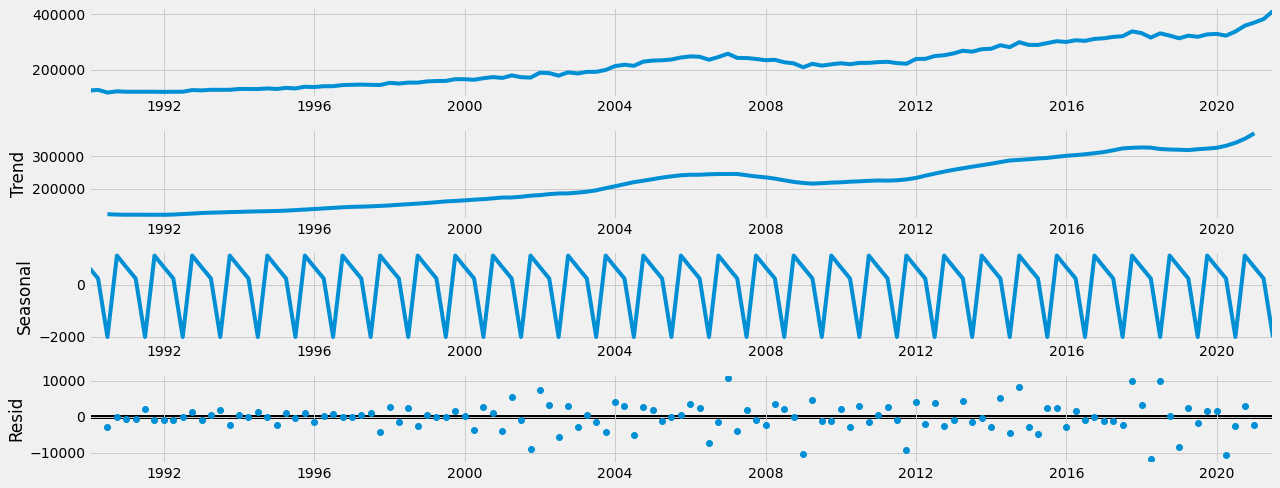

In [22]:
# Plotting the separate components

decomposition.plot()
plt.show()

From the above chart, the level and underlying trend are more or less the same, indicating a linear trend upwards with a slight dip in the late 2000s. 

Regarding seasonability, we can observe seasonal fluctations which is represented by the spikey curve that changes at regular intervals. 

Lastly, regarding the residual findings, there is a good bit of fluctuations and unexplained noise from the period from early 2000 to 2020. In the 1990s, the residual is fairly constant/flat. 

# 04. Testing for stationarity

In [23]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.920730
p-value                          0.998561
Number of Lags Used             11.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


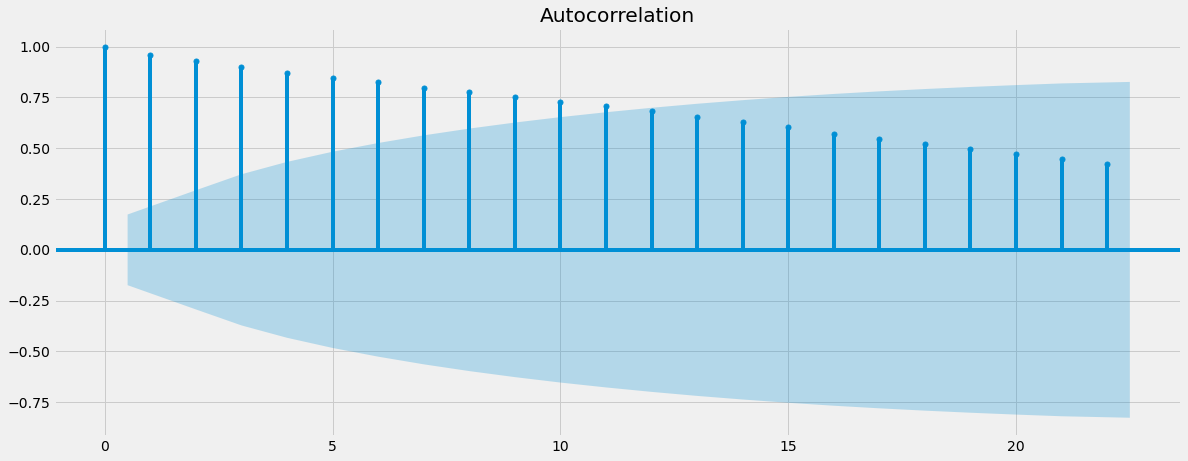

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The above chart shows that there are lags correlated with one another (representing by the lines that go above the blue shaded area), meaning that there is a lot of autocorrelated data and the set is non-stationary. 

# 05. Stationarizing the Federal Reserve Economic Data

In [25]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [27]:
data_diff.head()

,Value
datetime,
1990-04-01,2900.0
1990-07-01,-9800.0
1990-10-01,4500.0
1991-01-01,-1500.0
1991-04-01,-100.0


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

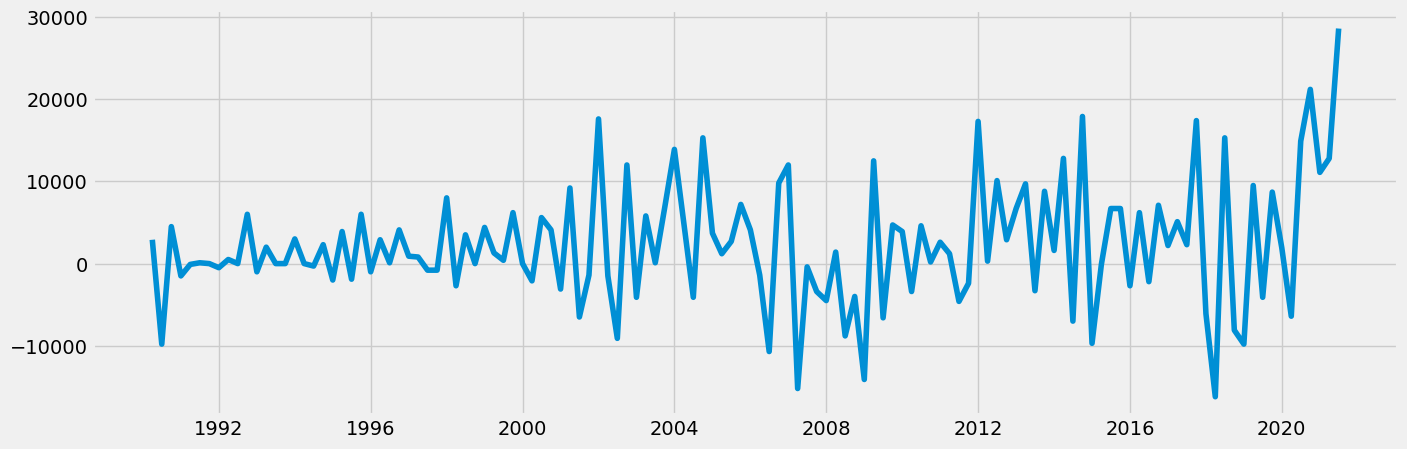

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.351648
p-value                          0.155851
Number of Lags Used              9.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


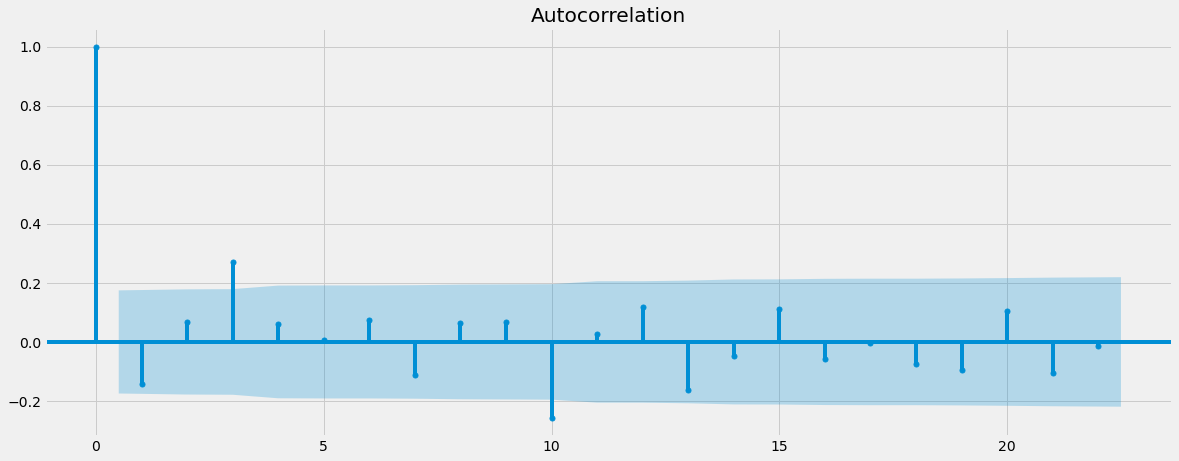

In [31]:
plot_acf(data_diff)
plt.show()

While the above stationarity has improved significantly, there is still weak stationarity. Moreover, based on the test statistic, which is still larger than the 5 and 10% critical values, I will again run another round of differencing to stationarize the data further, which will reduce the remaing autocorrelated terms. 

# Stationarizing again due to results of DF test

In [39]:
data_diff_2 = data_diff - data_diff.shift(1)

In [40]:
data_diff_2.dropna(inplace = True)

In [41]:
data_diff_2.head()

,Value
datetime,
1990-07-01,-12700.0
1990-10-01,14300.0
1991-01-01,-6000.0
1991-04-01,1400.0
1991-07-01,200.0


In [42]:
data_diff_2.columns

Index(['Value'], dtype='object')

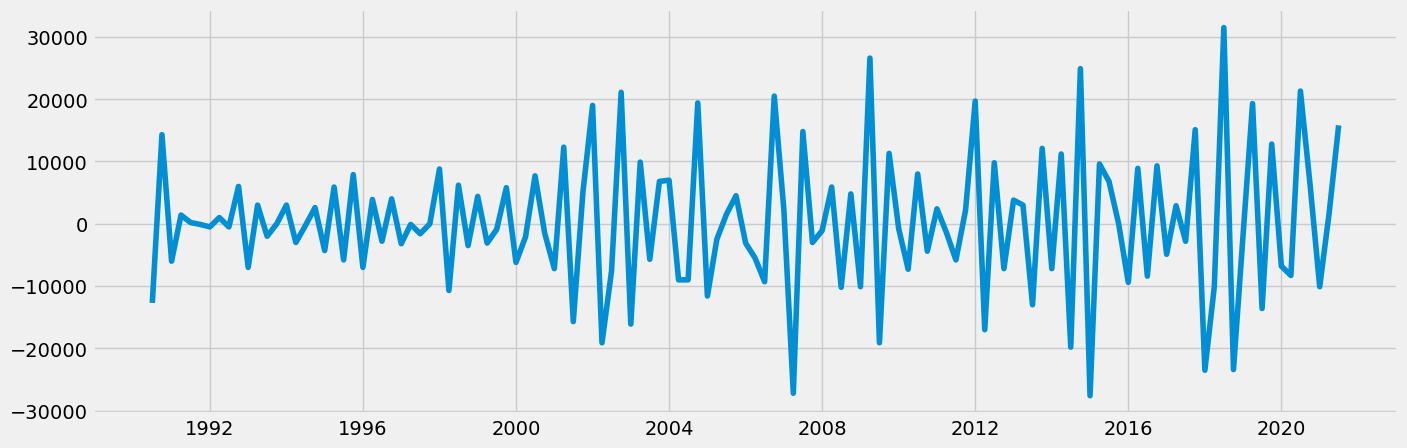

In [43]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [44]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.670942e+00
p-value                        1.277445e-16
Number of Lags Used            3.000000e+00
Number of Observations Used    1.210000e+02
Critical Value (1%)           -3.485585e+00
Critical Value (5%)           -2.885739e+00
Critical Value (10%)          -2.579676e+00
dtype: float64


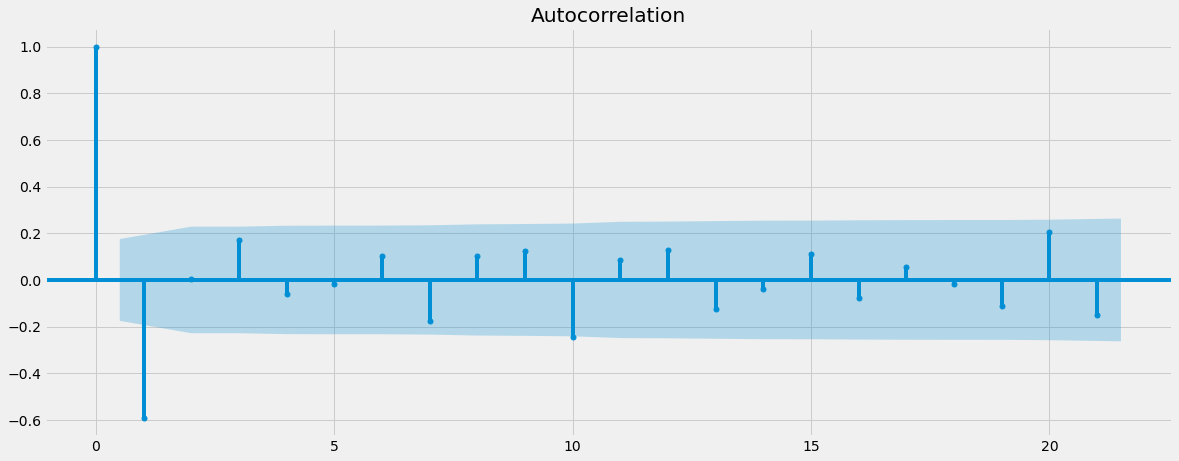

In [45]:
plot_acf(data_diff_2)
plt.show()

Following a second round of differencing, we can observe that based on the dickey-fuller test, our test statistic now is significantly lower than the critical values (1%, 5%, and 10%). Further, based on the plot, we can observe that there no signfiicant lag above the confidence interval (blue shading).